<a href="https://colab.research.google.com/github/ChasingCode34/facial-recognition-app/blob/main/Dependencies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

##1.1 Install Dependencies

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [9]:
!pip install opencv-python
!pip install opencv-contrib-python

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.2 Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import TensorFlow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


## 1.3: Set GPU Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## 1.4: Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


In [ ]:
POS_PATH

'data/positive'

In [6]:
faceid_path = "faceid"
os.makedirs(faceid_path)

# 2. Collect Positives and Anchors

## Untar LFW Dataset

In [6]:
!unzip lfw-deepfunneled.zip

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pak_Gil_Yon/Pak_Gil_Yon_0001.jpg  
   creating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0001.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0002.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0003.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0004.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/
  inflating: lfw-deepfunneled/lfw-deepfunneled/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/
  inflating: lfw-deepfunneled/lfw-deepfunneled/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: lfw-deepfunneled/lfw-deepfunneled/Parador

In [14]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw-deepfunneled') :
  for file in os.listdir(os.path.join('lfw-deepfunneled', directory)) :
    EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

## 2.2: Collect Positive and Anchor Classes

In [17]:
for directory in os.listdir('data/negative') :
  for file in os.listdir(os.path.join('data/negative', directory)) :
    EX_PATH = os.path.join('data/negative', directory, file)
    print(EX_PATH)

Streaming output truncated to the last 5000 lines.
data/negative/Joan_Laporta/Joan_Laporta_0008.jpg
data/negative/Joan_Laporta/Joan_Laporta_0006.jpg
data/negative/Joan_Laporta/Joan_Laporta_0005.jpg
data/negative/Joan_Laporta/Joan_Laporta_0007.jpg
data/negative/Joan_Laporta/Joan_Laporta_0004.jpg
data/negative/Joan_Laporta/Joan_Laporta_0009.jpg
data/negative/Joan_Laporta/Joan_Laporta_0003.jpg
data/negative/Joan_Laporta/Joan_Laporta_0001.jpg
data/negative/Joan_Laporta/Joan_Laporta_0002.jpg
data/negative/Lili_Marinho/Lili_Marinho_0001.jpg
data/negative/Tim_Conway/Tim_Conway_0003.jpg
data/negative/Tim_Conway/Tim_Conway_0001.jpg
data/negative/Tim_Conway/Tim_Conway_0002.jpg
data/negative/Joseph_Deiss/Joseph_Deiss_0002.jpg
data/negative/Joseph_Deiss/Joseph_Deiss_0003.jpg
data/negative/Joseph_Deiss/Joseph_Deiss_0001.jpg
data/negative/Brad_Russ/Brad_Russ_0001.jpg
data/negative/Bob_Petrino/Bob_Petrino_0001.jpg
data/negative/Barrett_Jackman/Barrett_Jackman_0001.jpg
data/negative/Barrett_Jackman/Ba

In [18]:
for directory in os.listdir('data/negative') :
  for file in os.listdir(os.path.join('data/negative', directory)) :
    EX_PATH = os.path.join('data/negative', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [21]:
for entry in os.scandir('data/negative') :
  if entry.is_dir() :
    os.rmdir(entry.path)

In [17]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 250;
      canvas.height = 250;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


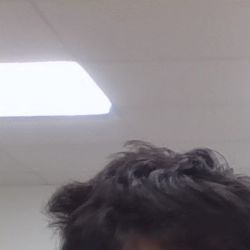

In [19]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

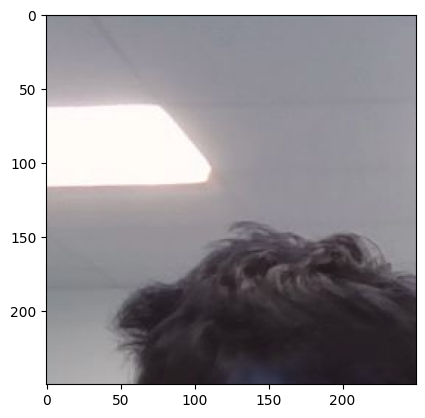

In [20]:
image = cv2.imread('photo.jpg')

plt.imshow(image[200:200+250, 200:200+250, :])


In [7]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  # Show image back to screen
  cv2.imshow('Image Collection', frame)

  # Breaking gracefully
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

# Release the webcam
cap.release()
# Close the image show frame
# cv2.destroyAllWindows()

In [9]:
!unzip anchor.zip

Archive:  anchor.zip
   creating: anchor/
  inflating: anchor/12d7862c-b2b2-11ef-a5a6-d8f883a00ac7.jpg  
  inflating: anchor/12e5b992-b2b2-11ef-b9d6-d8f883a00ac7.jpg  
  inflating: anchor/12ea8957-b2b2-11ef-b6a4-d8f883a00ac7.jpg  
  inflating: anchor/156f52df-b2b2-11ef-bf4c-d8f883a00ac7.jpg  
  inflating: anchor/162b6fbc-b2b2-11ef-93d8-d8f883a00ac7.jpg  
  inflating: anchor/16885970-b2b2-11ef-87c4-d8f883a00ac7.jpg  
  inflating: anchor/1694b292-b2b2-11ef-920a-d8f883a00ac7.jpg  
  inflating: anchor/1699690a-b2b2-11ef-953f-d8f883a00ac7.jpg  
  inflating: anchor/16ade886-b2b2-11ef-8115-d8f883a00ac7.jpg  
  inflating: anchor/16b2bd12-b2b2-11ef-87cb-d8f883a00ac7.jpg  
  inflating: anchor/16b75636-b2b2-11ef-acf5-d8f883a00ac7.jpg  
  inflating: anchor/1722ed6d-b2b2-11ef-87f3-d8f883a00ac7.jpg  
  inflating: anchor/178b79c0-b2b2-11ef-a1b8-d8f883a00ac7.jpg  
  inflating: anchor/1799cfc9-b2b2-11ef-8de5-d8f883a00ac7.jpg  
  inflating: anchor/17a14376-b2b2-11ef-b90c-d8f883a00ac7.jpg  
  inflating: 

In [11]:
# Move LFW Images to the following repository data/positive and data/anchor
import os
import shutil

# Move LFW Images to the following repository data/positive and data/anchor
for item in os.listdir('positive_unzip'):
    item_path = os.path.join('positive_unzip', item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # If it's a file, move it to POS_PATH
        NEW_PATH = os.path.join(POS_PATH, item)
        shutil.move(item_path, NEW_PATH)
    # If it's a directory, process its contents recursively (if needed)
    # elif os.path.isdir(item_path):
    #     # Add logic here to handle directories if necessary

for item in os.listdir('anchor_unzip'):
    item_path = os.path.join('anchor_unzip', item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # If it's a file, move it to ANC_PATH
        NEW_PATH = os.path.join(ANC_PATH, item)
        shutil.move(item_path, NEW_PATH)
    # If it's a directory, process its contents recursively (if needed)
    # elif os.path.isdir(item_path):
    #     # Add logic here to handle directories if necessary

# 3. Load and Preprocess Images

## 3.1: Get Image Directories

In [22]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [23]:
dir_test = anchor.as_numpy_iterator()

In [27]:
dir_test.next()

b'data/anchor/81c4c46f-b2b2-11ef-b545-d8f883a00ac7.jpg'

## 3.2 Preprocessing - Scale and Resize

In [28]:
def preprocess(file_path) :

  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resizing the image to be 100x100x3
  img = tf.image.resize(img, (100, 100))

  # Scale images between 0 and 1
  img = img / 255.0

  return img

In [ ]:
dataset.map(preprocess)

## 3.3: Create Labelled Dataset

In [29]:
# (anchor, positive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive.concatenate(negative)

In [35]:
samples = data.as_numpy_iterator()
example = samples.next()

## 3.4: Build Train and Test Partition

In [33]:
def preprocess_twin(input_img, validation_img, label) :
  return(preprocess(input_img), preprocess(validation_img), label)

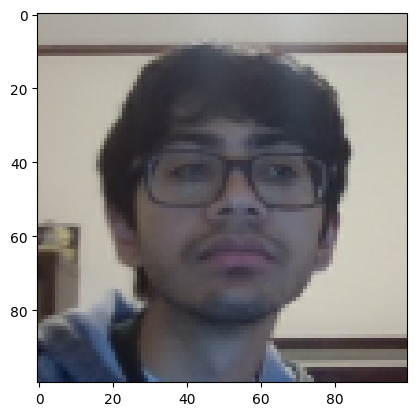

In [40]:
res = preprocess_twin(*example)
plt.imshow(res[1])

In [41]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [48]:
samples = data.as_numpy_iterator()
example = samples.next()


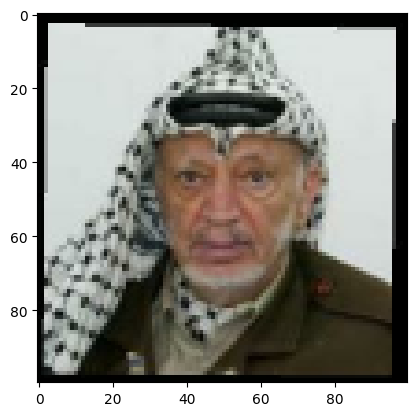

In [50]:
plt.imshow(example[1])

In [51]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)
round(len(data)*.7)

420

In [52]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [53]:
len(train_sample[0])

16

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# 4. Model Engineering

## 4.1: Build Embedding Layer

In [ ]:
def make_embedding() :

  return Model(inputs=, ouputs=, name=)